# --- classify cc voxels based on their gradient-prevalence profile ---

The subsequent code was used in Friedrich, Forkel & Thiebaut de Schotten, 2020 (https://www.researchgate.net/publication/339741859_Mapping_the_principal_gradient_onto_the_corpus_callosum) in the supplementary material.

The aim of the above referenced paper was to map the principal gradient onto the corpus callosum. The process of how we did this is shown below. For details please read the method section of the paper ;)

<img src="git_figs/01_wAverage_method.jpeg">

The result was a projection of the principal gradient onto the corpus callosum...

...However, other researchers may want to get a clear seperation of the callosal voxels (pointed out during the review process. So we thank the unknown reviewer for her/his suggestion! :) ).

Therefor, the following code is designed to create a hard-border segementation of the corpus callosum based on it's connectivity with cortical areas that are ordered by their similarity in resting-state fMRI (aka the principal gradient; Margulies et al., 2016, PNAS).

The result is shown below (:

<img src="git_figs/02_figureS1-B.jpeg">

##### import modules

In [1]:
### standard stuff
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### import modules for the tasks
import nibabel as nib # work with niftis
import umap           # dimension reduction
import hdbscan        # clustering

### evaluation:
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

/Users/beaudet/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


##### directories and apply mask (... and reshape for clustering --> later step)

In [13]:
##### requirements #####
# mask
ccMask = nib.load("git_data/ccmask.nii.gz") # please change this path, if you use another mask!
ccMaskD = ccmask.get_fdata()
# visitation maps (sample-based tractograms to the distinct gradient levels)
discon_dir = "git_data/discon"
# result directory
masked_discon = "git_data/discon_masked"


##### a vessel for the clustering #####
df = []


##### create masked visitation maps #####
for grad in sorted(os.listdir(discon_dir)):
    if grad.startswith("grad") and grad.endswith ("nii.gz"):
        gradpath = discon_dir+"/"+grad
# get the visitation map infos
        img = nib.load(gradpath)
        img_header = img.header.copy()
        imgD = img.get_fdata()
# create masked image
        outn = grad.split(".")[0]+"_masked.nii.gz"   # define the name of file
        outp = "git_data/discon_masked/"+outn   # define output path
        result = ccMaskD * imgD   # apply mask
# for later steps!!!
        ccMaskD_1d = ccMaskD.reshape(-1)
        result_masked = result.reshape(-1)[np.where(ccMaskD_1d)] # this reshapes to 1D and applies the mask
        df.append(result_masked)
# save result as nii.gz
        newImg = nib.nifti1.Nifti1Image(result, None, header=img_header) # create nii with correct header
        nib.save(newImg, outp) # save it :)
print(''' done :)''')


 done :)


##### dataframe for UMAP

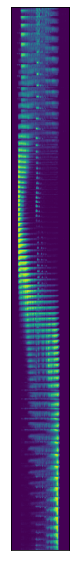

In [17]:
### convert to np.matrix
D = np.matrix(df)
dataT = D.T # transpose, as we are interested to reduce the number of gradient values

### only include the voxels from 13 to 82 grad value
dataT_13to82 = dataT[:,12:81]

### visualize the dataframe
fig = plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(dataT)
plt.show()

##### Test UMAP params - number of dimensions
UMAP reduces the dimensionality of the data, buw how many dimensions are "ideal"?
We run HDBSCAN (without changing any parameters) to see how many of the voxels in the ccMask can be classified. This will be our criteria.
The number of classified voxels will change depending on the number of dimensions.
In the following panel, we will pick the one number of dimensions with the highest number of classified voxels in this "vanila"-HDBSCAN run.

In [ ]:
### vessel for UMAP_params
UMAP_params = {}
results = []

### find best params
for i in range(2, dataT.shape[1]+1):
    name = "clusterable_embedding_"+str(i)
# UMAP    
    UMAP_params[name] = umap.UMAP(
    random_state=25,
    n_neighbors=30,
    min_dist=0.0,
    n_components=i).fit_transform(dataT) # 
# HDBSCAN
    clusterer = hdbscan.HDBSCAN().fit(UMAP_params[name])
    label = hdbscan.HDBSCAN().fit_predict(UMAP_params[name])
    clustered = (label >= 0)
# result
    nrClusteredVoxels = np.sum(clustered) / dataT.shape[0]
    results.append(nrClusteredVoxels)
    print("{n} : {res}".format(n=name, res=nrClusteredVoxels))

##### Test HDBSCAN params - cluster & sample size
After deciding which how many embedded dimensions we use, we can now look at the parameters in our clustering algorithm and try to optimize them. This time, the "best" parameters produce the highest number of classified voxels BUT at least 5 clusters (please see the excel-table in git_data called "infoHDBSCAN_paramTest).... you can obviously try out other goals for your optimization process.

In [ ]:
### define embedding of interest (the one with the highest number of classified voxels)
emb = UMAP_params["clusterable_embedding_53"]

### vessel
infoHDBSCAN = []

### loop
for i in range(2, dataT.shape[1]+1):
    cName = "c"+str(i)+"_s"
    for j in range(2, dataT.shape[1]+1):
        name = cName+str(j)
        # clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j).fit(emb)
        label = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j).fit_predict(emb)
        # evaluation
        clustered = (label >= 0)
        percentClassifiedVoxels = np.sum(clustered) / dataT.shape[0]
        res = name+" "+str(percentClassifiedVoxels)+" "+str(label.max())
        infoHDBSCAN.append(res)
        print(res)
        

### save this all as a searchable txt-file
with open('git_data/infoHDBSCAN_paramTest.txt', 'w') as f:
    for line in infoHDBSCAN:
        f.write(line+"\n")
print('done')

##### Visualize and save outputs :)
In our case, the "optimal" params were 11 and 2.... so we included these params in the following cell (i and j). The code below will give us the parcellation as nii.gz and some nice pictures :)

In [ ]:
### clustering
i = 11
j = 2
clusterer = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j).fit(emb)
label = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j).fit_predict(emb)
clustered = (label >= 0)

### figure
fig = plt.figure(figsize=(8,8))
#ax = fig.add_subplot(111, projection='polar')
ax = fig.add_subplot(111)
clustered = (label >= 0)
ax.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            facecolors='none',
            edgecolors='black',
            s=15)
ax.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=label[clustered],
            s=15,
            cmap='hsv')
#plt.savefig('visualized_embedding.PDF')

index = np.arange(len(ccMaskD_1d))
indexMasked = index[np.where(ccMaskD_1d)] # this contains only the 900+ indices needed
empty = np.zeros(len(ccMaskD_1d))
filled = empty
np.put(filled, indexMasked, invert) # inserts the label values at the position of CC
result = filled.reshape(ccMaskD.shape)

### output nifti
new_header = header=nib.load(epath).header.copy()
img = nib.nifti1.Nifti1Image(result, None, header=new_header)
img.get_data_dtype()
nib.save(img, "cc_parcellated.nii.gz")

##### If you use this code, please make sure to cite our work as well as the amazing(!) algorithms created by Leland McInnes:

Friedrich, P., Forkel, S. J., & de Schotten, M. T. (2020). Mapping the principal gradient onto the corpus callosum. bioRxiv.

McInnes, L., Healy, J., & Melville, J. (2018). Umap: Uniform manifold approximation and projection for dimension reduction. arXiv preprint arXiv:1802.03426.

McInnes, L., Healy, J., & Astels, S. (2017). hdbscan: Hierarchical density based clustering. Journal of Open Source Software, 2(11), 205.